<a href="https://colab.research.google.com/github/nagahara-masaaki/spm_python/blob/main/Sparse_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.3 CVXによる数値最適化

永原、スパースモデリング（コロナ社）、2.3節

## Initialization

Install CVXPY

In [1]:
! pip install cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import packages

In [30]:
import cvxpy as cp
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline

## Sparse polynomial curve fitting

Generate data

In [66]:
# Original coefficient vector
n = 81
x_orig = np.zeros(n)
x_orig[0] = -1
x_orig[n-2] = 1

# Measurement vetor y
m = 11
delta = 1/(m-1)
t = np.arange(0,1+delta,delta)
y = np.polyval(x_orig,t)

10-th interpolating polynomial

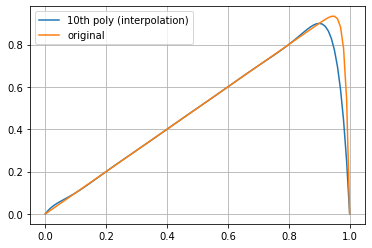

In [67]:
# Vandermonde matrix
Phi = np.vander(t)
# Solve linear equation Phi * x = y
x_11 = LA.solve(Phi,y)
# Plot the obtained curve
mm = 101
dd = 1/(mm-1)
time = np.arange(0,1+dd,dd)

fig, ax = plt.subplots()
ax.plot(time, np.polyval(x_11,time), label='10th poly (interpolation)')
ax.plot(time, np.polyval(x_orig,time), label='original')
ax.legend()
ax.grid()


Ridge regression (L2 regularization)

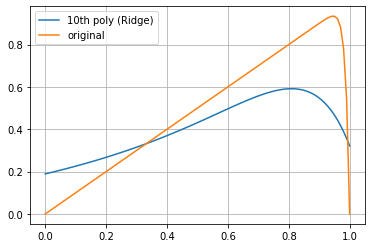

In [68]:
# Regularization parameter lambda
lmbd = 0.2
# Solve L2 regularization
A = np.identity(m) + np.dot(Phi.T,Phi)
b = np.dot(Phi.T,y)
x_ridge = LA.solve(A,b)
# Plot the obtained curve
fig, ax = plt.subplots()
ax.plot(time, np.polyval(x_ridge,time), label='10th poly (Ridge)')
ax.plot(time, np.polyval(x_orig,time), label='original')
ax.legend()
ax.grid()


Ridge regression (L2 regularization), 80th polynomial

(-1.0, 1.0)

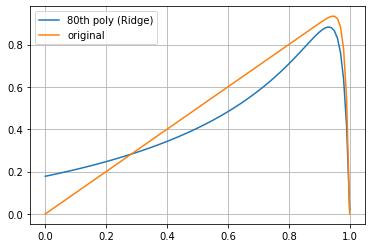

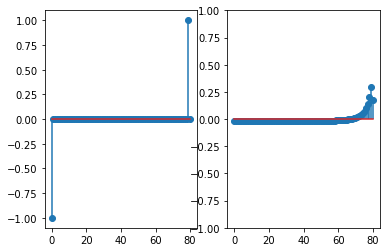

In [74]:
# Extended Vandermonde matrix
Phi_e = np.vander(t,n)
# Regularization parameter lambda
lmbd = 0.2
# Solve L2 regularization
A = np.identity(n) + np.dot(Phi_e.T,Phi_e)
b = np.dot(Phi_e.T,y)
x_ridge = LA.solve(A,b)

# Plot the obtained curve
fig, ax = plt.subplots()
ax.plot(time, np.polyval(x_ridge,time), label='80th poly (Ridge)')
ax.plot(time, np.polyval(x_orig,time), label='original')
ax.legend()
ax.grid()

# Plot the obtained coefficients
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.stem(x_orig,use_line_collection=True)
ax2 = fig.add_subplot(1, 2, 2)
ax2.stem(x_ridge,use_line_collection=True)
plt.ylim(-1,1)

Sparse modeling

status: optimal
optimal value 1.9999999994152589


(-1.0, 1.0)

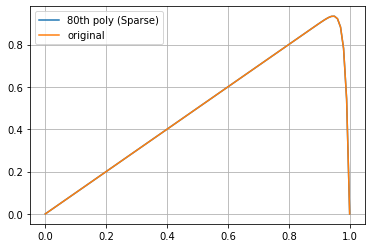

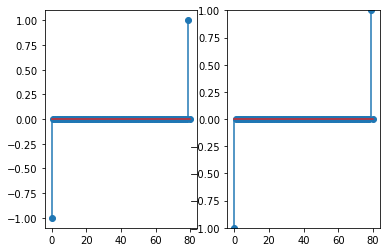

In [75]:
# Extended Vandermonde matrix
Phi_e = np.vander(t,n)
# optimization variable
x = cp.Variable(n)
# cost function (L1 norm)
cost = cp.norm1(x)
# constraints (linear equations)
constraints = [Phi_e @ x == y]
# optimization problem
prob = cp.Problem(cp.Minimize(cost), constraints)
# solve by CVXPY
prob.solve()
# print the result
print("status:", prob.status)
print("optimal value", prob.value)

# Plot the obtained curve
fig, ax = plt.subplots()
ax.plot(time, np.polyval(x.value,time), label='80th poly (Sparse)')
ax.plot(time, np.polyval(x_orig,time), label='original')
ax.legend()
ax.grid()

# Plot the obtained coefficients
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.stem(x_orig,use_line_collection=True)
ax2 = fig.add_subplot(1, 2, 2)
ax2.stem(x.value,use_line_collection=True)
plt.ylim(-1,1)

## Random measurement matrix

In [76]:
# vector size
n = 1000
k = 5
# random seed
np.random.seed(1)
# original vector (n-dimensional, k-sparse)
x_orig = np.zeros(n)
S = np.random.randint(n,size=k)
x_orig[S] = 1

Measurement matrix $A$

In [77]:
# measurement matrix (random matrix)
m = 100
A = np.random.randn(m, n)

Measurement vector $b$

In [87]:
# measurement vector
b = np.dot(A, x_orig) + np.random.randn(m) * np.sqrt(0.1)

In [88]:
b.shape

(100,)

Optimization $$\text{minimize} ~ \|x\|_1 ~~ \text{subjec to} ~ Ax = b$$

In [89]:
# optimization variable
x = cp.Variable(n)
# cost function (L1 norm)
cost = cp.norm1(x)
# constraints (linear equations)
constraints = [A @ x == b]
# optimization problem
prob = cp.Problem(cp.Minimize(cost), constraints)
# solve by CVXPY
prob.solve()
# print the result
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value 6.391310934868206


Figures

<StemContainer object of 3 artists>

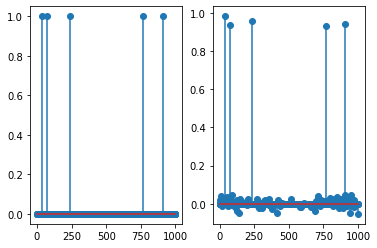

In [90]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.stem(x_orig,use_line_collection=True)
ax2 = fig.add_subplot(1, 2, 2)
ax2.stem(x.value,use_line_collection=True)

Optimization (LASSO) $$\text{minimize} ~ \|Ax-b\|_2^2 + \lambda \|x\|_1$$

status: optimal
optimal value 6.561499394348464


<StemContainer object of 3 artists>

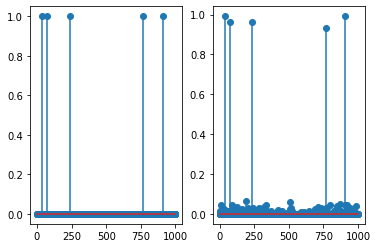

In [97]:
# optimization variable
x = cp.Variable(n)
# cost function (LASSO)
lmbd = 1
cost = cp.sum_squares(A @ x - b) + lmbd * cp.norm1(x)
# constraints (between 0 and 1)
constraints = [0 <= x, x <= 1]
# optimization problem
prob = cp.Problem(cp.Minimize(cost), constraints)
# solve by CVXPY
prob.solve()
# print the result
print("status:", prob.status)
print("optimal value", prob.value)

# Figures
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.stem(x_orig,use_line_collection=True)
ax2 = fig.add_subplot(1, 2, 2)
ax2.stem(x.value,use_line_collection=True)